In [6]:
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import random
import os
import zipfile
import json
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split

In [ ]:
with zipfile.ZipFile('/content/drive/My Drive/za_traffic_2020.zip', 'r') as zip_ref:
    zip_ref.extractall('zalo_ai')

In [ ]:
f = open('/content/zalo_ai/za_traffic_2020/traffic_train/train_traffic_sign_dataset.json')
json_file = json.load(f)

In [ ]:
annotation = []
for i in json_file['annotations']:
  annotation.append(('/content/zalo_ai/za_traffic_2020/traffic_train/images/' + str(i['image_id']) + '.png', i['bbox'], i['category_id']))
with open('/content/drive/My Drive/zalo_traffic_annotation.p', 'wb') as f:
  pickle.dump(annotation, f)

In [7]:
with open('/content/drive/My Drive/zalo_traffic_annotation.p', 'rb') as f:
  annotation = pickle.load(f)
annotation[0]

('/content/zalo_ai/za_traffic_2020/traffic_train/images/3.png',
 [880, 333, 19, 18],
 2)

In [ ]:
os.mkdir("/content/drive/My Drive/zalo_ai")

In [ ]:
for i in json_file['categories']:
  os.mkdir('/content/drive/My Drive/zalo_ai/' + str(i['id']))

In [ ]:
counter = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
for count, i in enumerate(json_file['annotations'], 0):
  pic =  str(i['image_id']) + '.png'
  image = Image.open("/content/zalo_ai/za_traffic_2020/traffic_train/images/" + pic)
  pixels = np.asarray(image)
  x1, y1, width, height = i['bbox']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = pixels[y1:y2, x1:x2]
  image = Image.fromarray(face)
  image = image.resize((32,32))
  image_name = str(counter[i['category_id']]) + '.png'
  image.save("/content/drive/My Drive/zalo_ai/" + str(i['category_id']) + '/' + image_name)
  counter[(i['category_id'])] = counter[(i['category_id'])] + 1
  if(count % 100 == 0):
    print("Done" + str(count))

In [ ]:
def load_split():
    # initialize the list of data and labels
    data = []
    labels = []
    count = 0
    for category in os.listdir("/content/drive/My Drive/zalo_ai/"):
      for img in os.listdir("/content/drive/My Drive/zalo_ai/" + category):
          img = Image.open("/content/drive/My Drive/zalo_ai/" + category + '/' + img)
          img = np.asarray(img)
          image = exposure.equalize_adapthist(img, clip_limit=0.1)
          data.append(image)
          labels.append(int(category))
          count = count + 1
          if count % 100 == 0:
            print(count)
    data = np.array(data)
    labels = np.array(labels)
    # return a tuple of the data and labels
    return (data, labels)

In [ ]:
#Load X and Y
(X, Y) = load_split()

In [ ]:
#Dump X and Y to disk
with open('/content/drive/My Drive/X_set.p', 'wb') as f:
  pickle.dump(X, f)
with open('/content/drive/My Drive/Y_set.p', 'wb') as f:
  pickle.dump(Y, f)

In [31]:
#Load X and Y from disk
with open('/content/drive/My Drive/X_set.p', 'rb') as f:
  X = pickle.load(f)
with open('/content/drive/My Drive/Y_set.p', 'rb') as f:
  Y = pickle.load(f)

In [30]:
to_categorical([1,2,3,4,5,6,7])

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [9]:

for i in range(0, len(Y)):
  Y[i] = Y[i] - 1

In [33]:
numLabels = len(np.unique(Y))
Y = to_categorical(Y, numLabels + 1)
X = X.astype("float32") / 255.0

In [34]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.33)

In [35]:
# trainX = trainX.astype("float32") / 255.0
# testX = testX.astype("float32") / 255.0
# # one-hot encode the training and testing labels
# trainY = to_categorical(trainY, numLabels)
# testY = to_categorical(testY, numLabels)
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals
weight = dict(zip(set(np.argmax(Y, axis=1)), classWeight))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [36]:
weight

{1: inf,
 2: 2.1340313,
 3: 1.3901774,
 4: 5.2390747,
 5: 3.1499226,
 6: 1.6969192,
 7: 1.0}

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
def build(width, height, depth, classes):
  # initialize the model along with the input shape to be
  # "channels last" and the channels dimension itself
  model = Sequential()
  inputShape = (height, width, depth)
  chanDim = -1
  # CONV => RELU => BN => POOL
  model.add(Conv2D(8, (5, 5), padding="same",
    input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # first set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # second set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  return model

In [17]:
NUM_EPOCHS = 200
INIT_LR = 1e-3
BS = 64

In [18]:
from keras.callbacks import EarlyStopping
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = build(width=32, height=32, depth=3,
	classes=7)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=0, mode='max')
mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
  validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=weight,
	callbacks=[earlyStopping, mcp_save]
  )

[INFO] compiling model...
[INFO] training network...
Epoch 1/200
115/115 [==============================] - 5s 47ms/step - loss: 2.5306 - accuracy: 0.5853 - val_loss: 2.7548 - val_accuracy: 0.1267
Epoch 2/200
115/115 [==============================] - 5s 43ms/step - loss: 1.3489 - accuracy: 0.7740 - val_loss: 4.1233 - val_accuracy: 0.1267
Epoch 3/200
115/115 [==============================] - 5s 43ms/step - loss: 1.0983 - accuracy: 0.8286 - val_loss: 3.6274 - val_accuracy: 0.1267
Epoch 4/200
115/115 [==============================] - 5s 44ms/step - loss: 0.9506 - accuracy: 0.8466 - val_loss: 3.1905 - val_accuracy: 0.2366
Epoch 5/200
115/115 [==============================] - 5s 44ms/step - loss: 0.8466 - accuracy: 0.8731 - val_loss: 1.2526 - val_accuracy: 0.5612
Epoch 6/200
115/115 [==============================] - 5s 43ms/step - loss: 0.7573 - accuracy: 0.8863 - val_loss: 0.4067 - val_accuracy: 0.8540
Epoch 7/200
115/115 [==============================] - 5s 44ms/step - loss: 0.6926 

In [ ]:
model.save('/content/drive/My Drive/traffic_sign_classified')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/traffic_sign_classified/assets


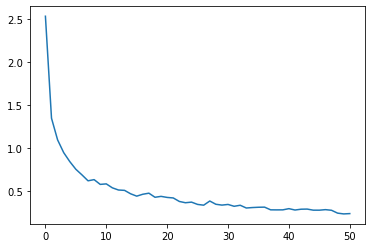

In [29]:
plt.plot(H.history.get("loss"))

In [1]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/traffic_sign_classified')

In [ ]:
category = [{'supercategory': 'Cấm ngược chiều', 'id': 1, 'name': 'Cam nguoc chieu'}, {'supercategory': 'Cam dung va do', 'id': 2, 'name': 'Cam dung va do'}, {'supercategory': 'Cấm rẽ', 'id': 3, 'name': 'Cam re'}, {'supercategory': 'Giới hạn tốc độ', 'id': 4, 'name': 'Gioi han toc do'}, {'supercategory': 'Cam con lai', 'id': 5, 'name': 'Cam con lai'}, {'supercategory': 'Nguy hiểm', 'id': 6, 'name': 'Nguy hiem'}, {'supercategory': 'Hiệu lệnh', 'id': 7, 'name': 'Hieu lenh'}]
label = {}
for i in category:
  label[i['id'] - 1] = i['name']

172/172 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1416
           1       0.99      0.99      0.99      2221
           2       0.91      0.96      0.94       556
           3       0.88      0.98      0.93       949
           4       0.97      0.90      0.93      1787
           5       1.00      1.00      1.00      3049
           6       0.99      0.99      0.99      1022

    accuracy                           0.97     11000
   macro avg       0.96      0.97      0.97     11000
weighted avg       0.98      0.97      0.97     11000



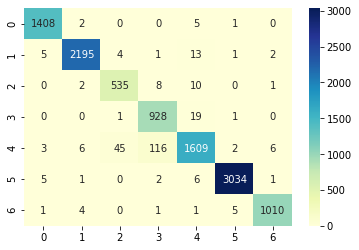

In [ ]:
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
y_pred = model.predict(X, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(Y, axis=1), y_pred_bool))
a = confusion_matrix(np.argmax(Y, axis=1), y_pred_bool)
sns.heatmap(pd.DataFrame(a), annot=True, cmap="YlGnBu" ,fmt='g')

In [ ]:
from google.colab.patches import cv2_imshow
def predict(path):
  img1 = Image.open(path)
  img1 = img1.resize((32,32))
  img1 = np.asarray(img1)
  if(len(img1.shape) < 3):
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
  img1 = exposure.equalize_adapthist(img1, clip_limit=1)
  img1 = img1 / 255.0
  img1 = np.array([img1])
  res = label[np.argmax(model.predict(img1))]
  
  img = cv2.imread(path)
  img = cv2.resize(img, (256,256))
  font = cv2.FONT_HERSHEY_SIMPLEX 
  # org 
  org = (20, 60) 
  # fontScale 
  fontScale = 0.6
  # Blue color in BGR 
  color = (255, 0, 0) 
  # Line thickness of 2 px 
  thickness = 1
  # Using cv2.putText() method 
  image = cv2.putText(img, res, org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
  #Display the image
  cv2_imshow(img)                                           


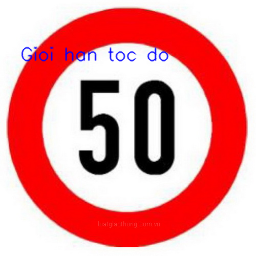

In [ ]:
predict('/content/traffic11.jpg')